# Source finding

## 1. Initialisation

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from time import time
from scipy import stats
import importlib
import scripts
importlib.reload(scripts)

scripts init
scripts init


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

## 2. Read data

In [2]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(32)

Read dataset 32: "Synthetic WSRT cube" (1464, 360, 360) (0.245 s)


## 3. Sort data

In [3]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(data.ravel())

Sorted 189734400 finite measurements in ascending order (44.6 s)


## 4. Hierarchical Overdensity Tree (HOT)

In [4]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'    ({time()-t0:.3g} s)')

HOT: 2774391 overdensities found, 189734400 "pixels" (100%), 1 independent regions
    (126 s)


In [5]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

## 5. Reliability

99 found above threshold 9.25e-07
98 with reliability > 0, 17 above 0.910818097683654 (0.319 s)


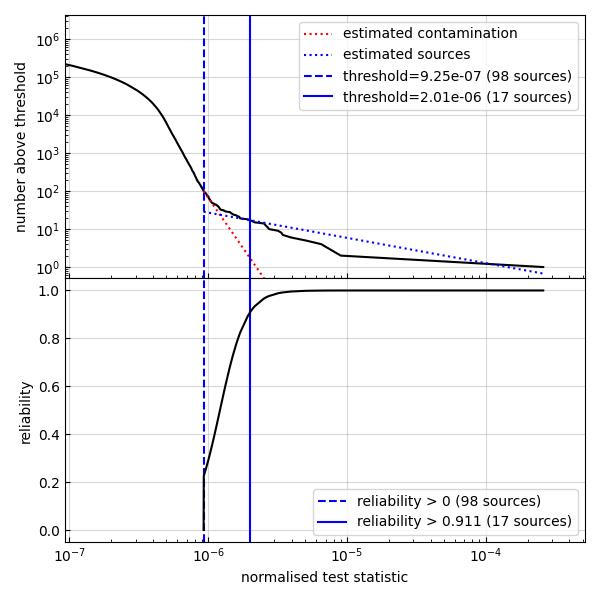

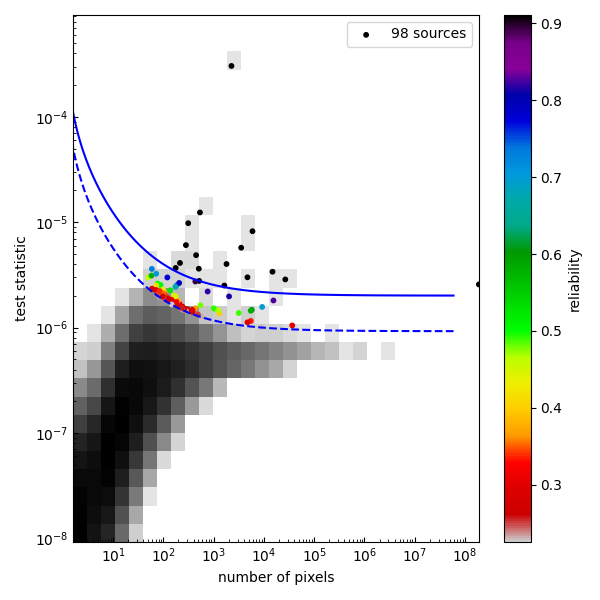

In [6]:
importlib.reload(scripts.reliability)
reliability, reliability_threshold = scripts.reliability.run(test_stat, area, plots=True)

In [7]:
true_overdensity = reliability > 0
#true_overdensity = reliability > reliability_threshold

n_sources = np.count_nonzero(true_overdensity)
n_reliable = np.count_nonzero(reliability > reliability_threshold)

In [8]:
plots = True
data_dimensionality = sorted_strides.size-1
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)

In [9]:
p50-3*(p50-p16), p0

(-0.004768773896785206, -0.008935184217989445)

## 8. Clean-up

### prune HOT based on selection threshold

In [10]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

2774294 yet to go
1852735 yet to go
1178816 yet to go
697296 yet to go
364482 yet to go
157802 yet to go
52396 yet to go
12616 yet to go
2186 yet to go
280 yet to go
17 yet to go
3 yet to go
1 yet to go


### rename labels and create final catalogues

In [11]:
final_labels = pruned_labels.astype(np.int32)
old_labels = np.unique(pruned_labels)
sorted_by_area = np.argsort(area[old_labels])[::-1]

new_label = np.zeros_like(parent)
n_final_labels = old_labels.size
old_label = np.zeros_like(old_labels)
print(f'{n_final_labels} objects after pruning')

for i, old_i in enumerate(sorted_by_area):
    lbl = old_labels[old_i]
    new_label[lbl] = i
    #final_labels[final_labels == lbl] = i # ???
    old_label[i] = lbl

new_parent = new_label[parent[old_labels]]
final_labels = new_label[pruned_labels[label]]

99 objects after pruning


In [12]:
if plots and data_dimensionality == 2:
    from photutils import segmentation as segm
    if n_sources > 0:
        final_selection = segm.SegmentationImage(final_labels)
        final_cmap = final_selection.make_cmap(seed=123)
        final_catalog = segm.SourceCatalog(data, final_selection)
        final_catalog.to_table()
    else:
        final_selection = final_labels
        final_cmap = 'viridis'

In [13]:
my_cmap = np.vstack([np.argsort(np.random.random(n_sources))/n_sources, np.argsort(np.random.random(n_sources))/n_sources, np.argsort(np.random.random(n_sources))/n_sources, np.ones(n_sources)]).T
final_cmap = colors.ListedColormap(my_cmap)

In [14]:
if plots and data_dimensionality == 2:
    plt.close('segmentation')
    fig = plt.figure('segmentation', figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower',
        #cmap='terrain', norm = colour_scale,
        #cmap='ocean', norm = colour_scale,
        cmap='nipy_spectral', norm = colour_scale,
        )
    #ax[0, 0].contour(final_labels, levels=[0.5], colors=['k'])
    #ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    #cb.ax.axhline(mode, c='k', ls=':')
    #cb.ax.axhline(data.threshold, c='w', ls='--')
    #cb.ax.axhline(2*mode-data.threshold, c='w', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    #ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
    if n_sources > 0:
        ax[0, 0].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='w', marker='+')

    '''
    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    #ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')
    '''
    ax[0, 1].set_title(f'segmentation ({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    if n_sources > 0:
        ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
        ax[0, 1].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='k', marker='+')
        final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')
    cb = fig.colorbar(im, ax=ax[0, 1])

    axis = ax[0, 2]
    #axis.set_title('Test statistic')
    axis.set_title('Reliability')
    im = axis.imshow(
        #np.log10(test_stat[label]/Chernoff_threshold),
        reliability[label],
        interpolation='nearest', origin='lower',
        #cmap='rainbow_r',
        #vmin=-3, vmax=3,
        cmap='nipy_spectral_r', vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        )
    cb = fig.colorbar(im, ax=axis)
    if n_sources > 0:
        ax[0, 2].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='w', marker='+')

    '''
    axis = ax[0, 3]
    axis.set_title('p_value')
    im = axis.imshow(
        test_stat_Chernoff[label],
        interpolation='nearest', origin='lower', cmap='rainbow',
        #vmin = 0, vmax = test_stat_threshold_max,
        )
    cb = fig.colorbar(im, ax=axis)
    '''


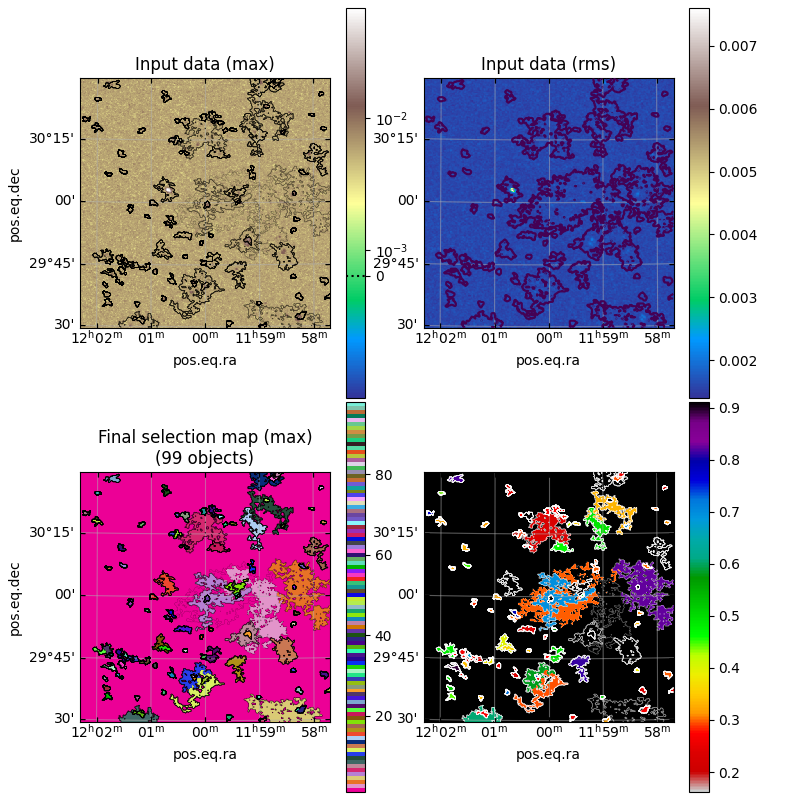

In [15]:
if plots and data_dimensionality == 3:

    mode = 0
    
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


/tmp/ipykernel_24595/1001690177.py:39: UserWarning: No contour levels were found within the data range.
  ax[1, 0].contour(vertical_slit, levels=0)
/tmp/ipykernel_24595/1001690177.py:63: UserWarning: No contour levels were found within the data range.
  ax[3, 0].contour(horizontal_slit, levels=0)
/home/yago/.local/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.figure.savefig(buf, format='png', dpi='figure')


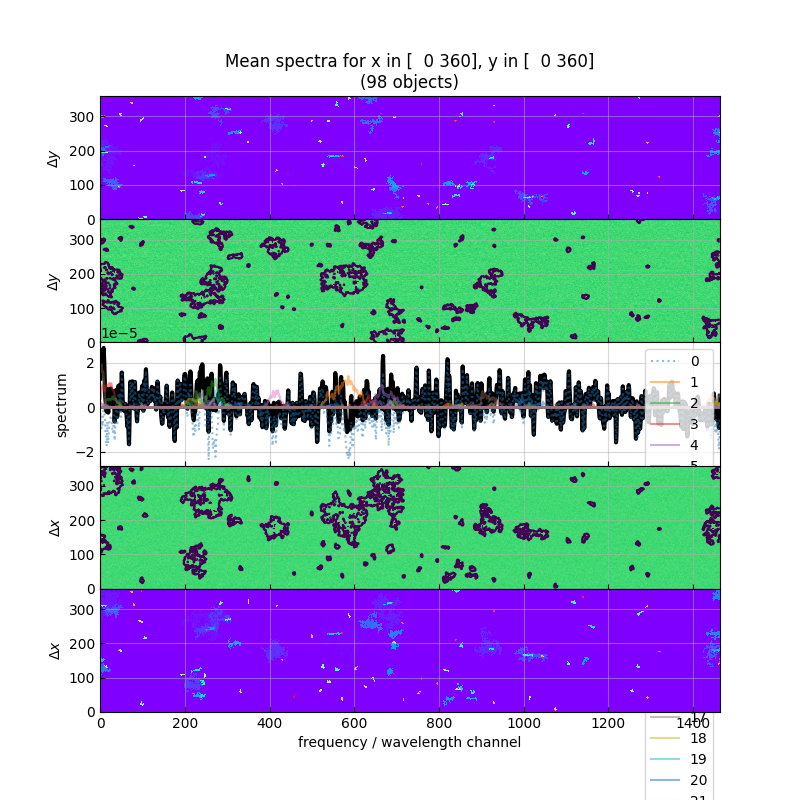

In [16]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [17]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


NameError: name 'fits' is not defined

In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
